# Summary of the Project

### This project focuses on clustering and categorizing NYC taxi trips based on trip duration and pickup times to identify patterns like peak hours and typical trip lengths. Using machine learning models and A/B testing, it aims to uncover insights that optimize fleet management, dynamic pricing, and resource allocation, ultimately enhancing operational efficiency and customer satisfaction.

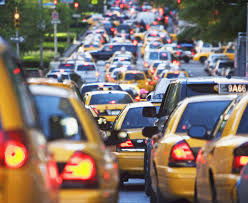

  ##  Descriptive Analysis:
        Summary statistics, distribution plots, and word clouds were used to understand the dataset.

 ##   Prescriptive Analysis:
        Hypothesis testing determined the relationship between trip duration and day of the week.
        A/B testing compared trip duration for two groups.

  ##   Predictive Analysis:
        Clustering grouped trips with similar patterns.
        Decision trees predicted trip duration categories based on time-related features.

In [13]:
# Install necessary packages
!pip install pyspark wordcloud

# Import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour, dayofweek, when, mean, count, stddev
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.clustering import KMeans
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
import numpy as np
from pyspark.sql.functions import col

# Initialize Spark Session

In [14]:
# Install necessary packages
!pip install pyspark wordcloud

# Import libraries
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder.appName("NYC_Taxi_Trip_Duration").getOrCreate()


##Setting up the Spark environment to handle Big Data for NYC Taxi trip duration.

##Enables efficient processing of large datasets, crucial for scaling analysis to city-wide taxi data.

In [15]:
# Load Dataset
data = spark.read.csv("nyc_taxi_trip_duration.csv", header=True, inferSchema=True)

# Inspect dataset
print("Schema of Dataset:")
data.printSchema()
print("Number of Records:", data.count())

Schema of Dataset:
root
 |-- id: string (nullable = true)
 |-- vendor_id: integer (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- trip_duration: integer (nullable = true)

Number of Records: 729322


### Load the NYC taxi dataset, check schema, and verify the number of records. Understand the dataset structure and size to identify potential bottlenecks and ensure data quality.

#EDA

+-------+------------------+
|summary|     trip_duration|
+-------+------------------+
|  count|            729322|
|   mean| 952.2291333594764|
| stddev|3864.6261972811944|
|    min|                 1|
|    max|           1939736|
+-------+------------------+



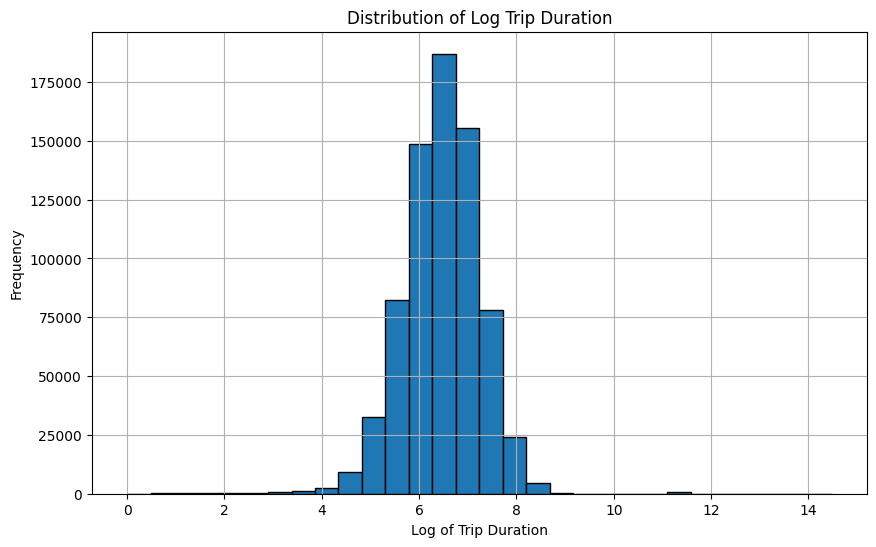

In [16]:
# Summary statistics
data.describe(["trip_duration"]).show()

# Distribution of trip duration (log-transformed for visualization)
trip_duration_pd = data.select("trip_duration").toPandas()
trip_duration_pd["log_trip_duration"] = trip_duration_pd["trip_duration"].apply(lambda x: max(1, x)).apply(np.log)

plt.figure(figsize=(10, 6))
plt.hist(trip_duration_pd["log_trip_duration"], bins=30, edgecolor="black")
plt.xlabel("Log of Trip Duration")
plt.ylabel("Frequency")
plt.title("Distribution of Log Trip Duration")
plt.grid(True)
plt.show()

###  Analyze trip duration distribution and visualize datetime information using a word cloud. Identifies the distribution and outliers in trip duration, helping in anomaly detection and process optimization. A log-transformed trip duration shows better normalization for statistical modeling.

# Time-Series Histogram
### A histogram showing the distribution of pickup times across days, hours, or months

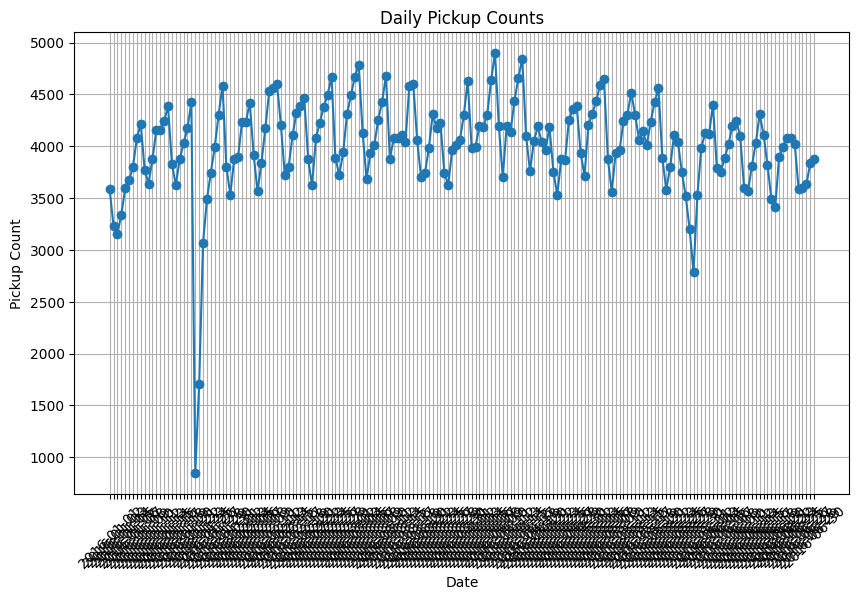

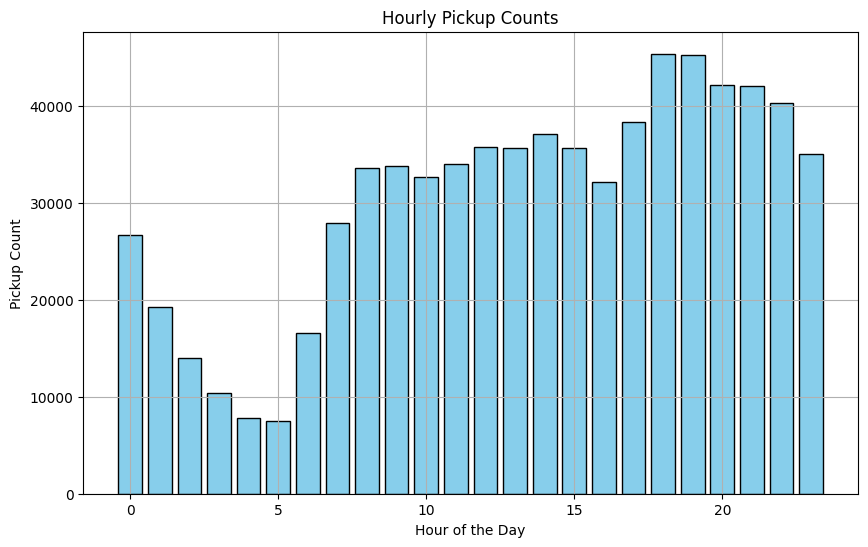

In [17]:
# Extract date and hour parts for analysis
data = data.withColumn("pickup_date", col("pickup_datetime").substr(1, 10))
data = data.withColumn("pickup_hour", hour(col("pickup_datetime")))

# Group by date to count pickups per day
date_counts = data.groupBy("pickup_date").count().orderBy("pickup_date")
date_counts_pd = date_counts.toPandas()

# Plot daily pickup counts
if not date_counts_pd.empty:
    plt.figure(figsize=(10, 6))
    plt.plot(date_counts_pd["pickup_date"], date_counts_pd["count"], marker="o")
    plt.xticks(rotation=45)
    plt.xlabel("Date")
    plt.ylabel("Pickup Count")
    plt.title("Daily Pickup Counts")
    plt.grid(True)
    plt.show()
else:
    print("No valid data available for date counts.")

# Group by hour to count pickups
hour_counts = data.groupBy("pickup_hour").count().orderBy("pickup_hour")
hour_counts_pd = hour_counts.toPandas()

# Plot hourly pickup counts
if not hour_counts_pd.empty:
    plt.figure(figsize=(10, 6))
    plt.bar(hour_counts_pd["pickup_hour"], hour_counts_pd["count"], color="skyblue", edgecolor="black")
    plt.xlabel("Hour of the Day")
    plt.ylabel("Pickup Count")
    plt.title("Hourly Pickup Counts")
    plt.grid(True)
    plt.show()
else:
    print("No valid data available for hour counts.")


# Heatmap of Pickups by Hour and Day
### A heatmap showing the pickup counts by hour and day of the week.

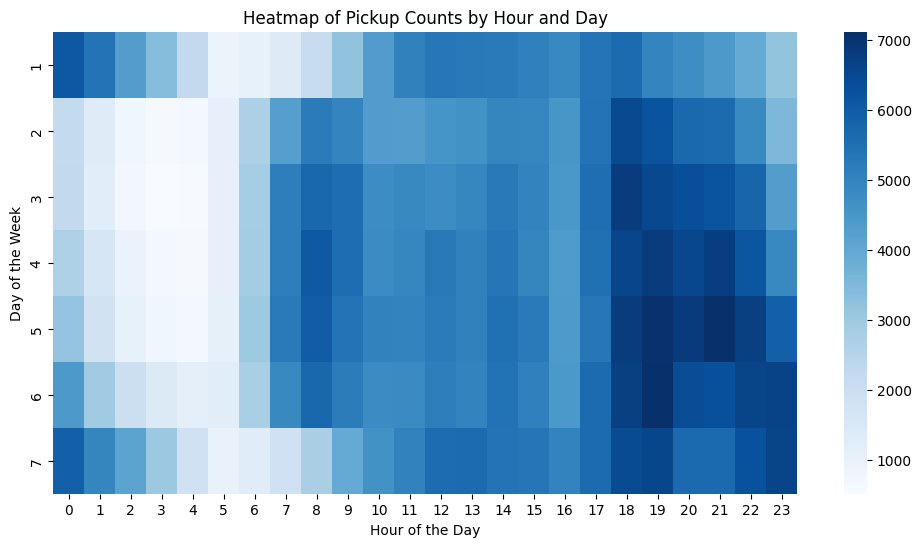

In [18]:
from pyspark.sql.functions import dayofweek
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Add day of the week column
data = data.withColumn("pickup_day", dayofweek(col("pickup_datetime")))

# Group by day and hour and convert to Pandas
heatmap_data = data.groupBy("pickup_day", "pickup_hour").count().toPandas()

# Pivot for heatmap
heatmap_pivot = heatmap_data.pivot(index="pickup_day", columns="pickup_hour", values="count")

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_pivot, cmap="Blues", annot=False, fmt="d")
plt.xlabel("Hour of the Day")
plt.ylabel("Day of the Week")
plt.title("Heatmap of Pickup Counts by Hour and Day")
plt.show()


### Highlights seasonality and long-term trends.

# Box Plot for Hourly Trends
### A box plot to analyze the distribution of trip durations across hours.

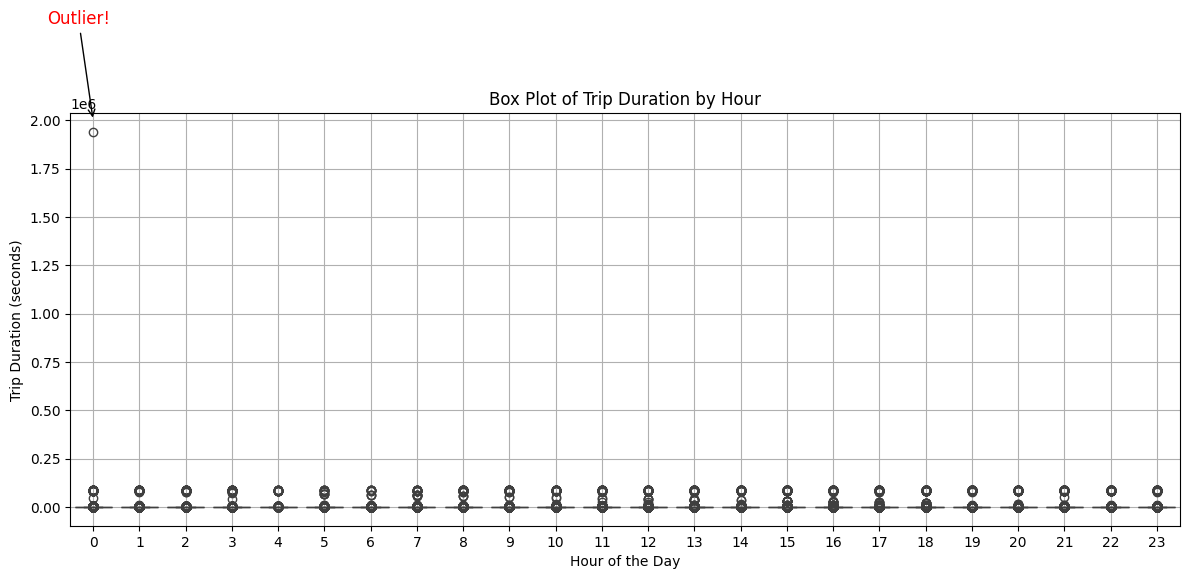

In [28]:
# Group by hour and calculate statistics
hourly_data = data.select("pickup_hour", "trip_duration").toPandas()

# Plot boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x="pickup_hour", y="trip_duration", data=hourly_data)
plt.xlabel("Hour of the Day")
plt.ylabel("Trip Duration (seconds)")
plt.title("Box Plot of Trip Duration by Hour")

# Add annotation for the outlier
plt.annotate(
    "Outlier!",  # Text
    xy=(0, 2.00e6),  # Coordinates for the arrow
    xytext=(-1, 2.5e6),  # Position of the text
    arrowprops=dict(facecolor="red", arrowstyle="->"),  # Arrow style
    fontsize=12,  # Text font size
    color="red"  # Text color
)

plt.grid(True)
plt.tight_layout()
plt.show()

### The issue likely arises from the presence of extreme outliers in the trip_duration data, which compresses the scale of the box plot.

### To address this, you can either limit the y-axis to exclude extreme outliers or use a log transformation to better visualize the data distribution. Lets youse Log Transformation to solve the problem

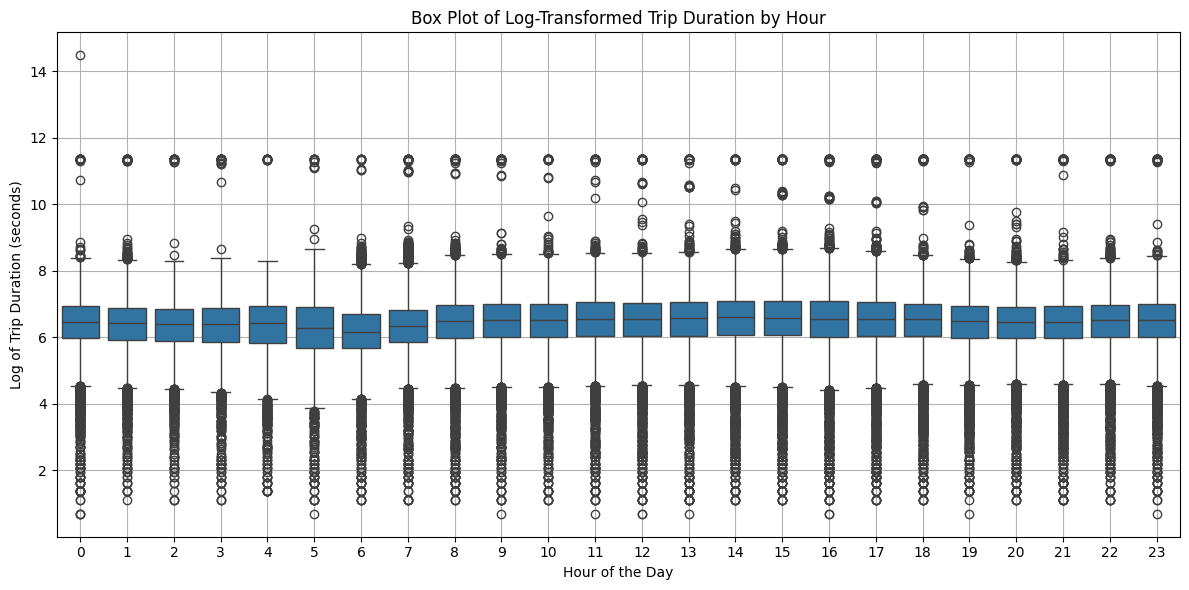

In [20]:
# Apply log transformation to trip_duration
hourly_data["log_trip_duration"] = hourly_data["trip_duration"].apply(lambda x: np.log1p(x))

# Plot boxplot with log-transformed data
plt.figure(figsize=(12, 6))
sns.boxplot(x="pickup_hour", y="log_trip_duration", data=hourly_data)
plt.xlabel("Hour of the Day")
plt.ylabel("Log of Trip Duration (seconds)")
plt.title("Box Plot of Log-Transformed Trip Duration by Hour")
plt.grid(True)
plt.tight_layout()
plt.show()


# Statistical Understanding
### A log transformation was applied to trip_duration using log(1+x) to reduce the impact of extreme values and stabilize variance. This transformation compresses large durations while preserving data relationships, making the distribution more symmetric and interpretable. The resulting boxplot highlights patterns and variability across pickup hours that would otherwise be obscured by skewness.

# Feature Engineering

In [21]:
# Dropping irrelevant columns
columns_to_drop = ["id", "vendor_id", "dropoff_datetime", "store_and_fwd_flag"]
data = data.drop(*columns_to_drop)

# Handling missing values
data = data.dropna()

# Adding new features
data = data.withColumn("pickup_hour", hour(col("pickup_datetime")))
data = data.withColumn("pickup_dayofweek", dayofweek(col("pickup_datetime")))


###  Enhance the dataset with features like pickup hour and day of the week. Helps identify patterns related to peak hours and weekdays, aiding in dynamic pricing and resource allocation. Improves model accuracy by incorporating time-based features.

# Hypothesis Testing

+----------------+------------------+------+------------------+
|pickup_dayofweek| avg_trip_duration| count|           std_dev|
+----------------+------------------+------+------------------+
|               1| 894.5710878155647| 97682|3391.6312691853605|
|               6|  990.022998997709|111744| 3245.450138580836|
|               3|  980.550279495131|101254| 6813.440228414399|
|               5|1005.4469289581505|109344|3092.3230096727966|
|               4| 975.8995565030359|105074|2869.8953664395485|
|               7| 913.9861136305917|110252| 3421.415495593196|
|               2|  893.184554973822| 93972| 2706.860492711748|
+----------------+------------------+------+------------------+



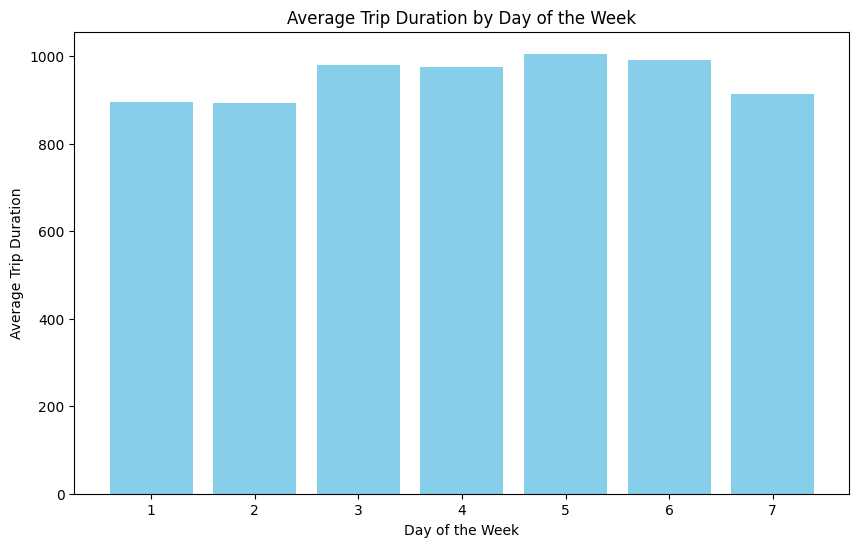

ANOVA Test Results:
F-statistic: 15.88, p-value: 0.0000
The differences in average trip duration across days of the week are statistically significant.


In [22]:
from scipy.stats import f_oneway

# Hypothesis Testing: Trip duration vs. Day of the Week
grouped_data = data.groupBy("pickup_dayofweek").agg(
    mean("trip_duration").alias("avg_trip_duration"),
    count("trip_duration").alias("count"),
    stddev("trip_duration").alias("std_dev")
)
grouped_data.show()

# Visualizing average trip duration by day of the week
grouped_pd = grouped_data.toPandas()
plt.figure(figsize=(10, 6))
plt.bar(grouped_pd["pickup_dayofweek"], grouped_pd["avg_trip_duration"], color="skyblue")
plt.xlabel("Day of the Week")
plt.ylabel("Average Trip Duration")
plt.title("Average Trip Duration by Day of the Week")
plt.show()

# Prepare data for ANOVA
anova_data = data.select("pickup_dayofweek", "trip_duration").toPandas()

# Group trip durations by day of the week
trip_durations_by_day = [
    anova_data[anova_data["pickup_dayofweek"] == day]["trip_duration"]
    for day in sorted(anova_data["pickup_dayofweek"].unique())
]

# Perform ANOVA test
f_stat, p_value = f_oneway(*trip_durations_by_day)

print(f"ANOVA Test Results:\nF-statistic: {f_stat:.2f}, p-value: {p_value:.4f}")

# Interpret the results
if p_value < 0.05:
    print("The differences in average trip duration across days of the week are statistically significant.")
else:
    print("There is no statistically significant difference in average trip duration across days of the week.")


## Bar Chart: Visualizes average trip durations for each day.
## ANOVA Results:
    ### F-statistic: Indicates the ratio of variance between groups to within groups.
    ### p-value: Tells whether the differences in means are statistically significant.

## Hypotheses Definition:

   ### Null Hypothesis (H0H0​): The average trip duration is the same across all days of the week.
  ###  Alternative Hypothesis (HaHa​): The average trip duration is different for at least one day of the week.

## Data Aggregation:

   ### The dataset is grouped by pickup_dayofweek (days of the week).
   ### For each day, the following statistics are calculated:
        Average Trip Duration (avg_trip_duration): Mean trip duration for that day.
        Count (count): Number of trips for that day.
        Standard Deviation (std_dev): Variability in trip durations for that day.

## Data Visualization:

   ### A bar chart is used to visualize the average trip duration for each day of the week. Differences in bar heights provide an initial visual cue about potential variation.

##  Statistical Test:

   ### To formally test the hypothesis, a statistical test like ANOVA (Analysis of Variance) could be applied to check if the differences in means are statistically significant.`

### Test if trip duration significantly varies across different days of the week. Guides operational planning (e.g., staffing levels, fleet availability) based on weekdays.  Identifies significant variations, supporting decisions with data-driven insights.

### ANOVA Test Results

   ## F-statistic: 15.88
        Indicates a substantial difference in the variance of average trip durations across days of the week compared to the variance within each day.

   ##  p-value: 0.0000
        Since the p-value is less than 0.05, we reject the null hypothesis, confirming that the differences in average trip durations across the days of the week are statistically significant

# Key Findings
### Statistical Significance:

    The analysis confirms that trip durations are influenced by the day of the week.

### Behavioral Trends:

    Weekdays: Likely dominated by shorter, routine commutes.
    Weekends: May have longer trips due to leisure activities and less congestion.

### Business Impact

    Operational Planning:
        Allocate more drivers on days with longer average trip durations to meet demand efficiently.
    Dynamic Pricing:
        Implement pricing strategies based on day-specific trip duration trends to maximize revenue.
    Customer Targeting:
        Tailor marketing campaigns for weekdays and weekends to match trip behavior.
  

# Clustering Analysis


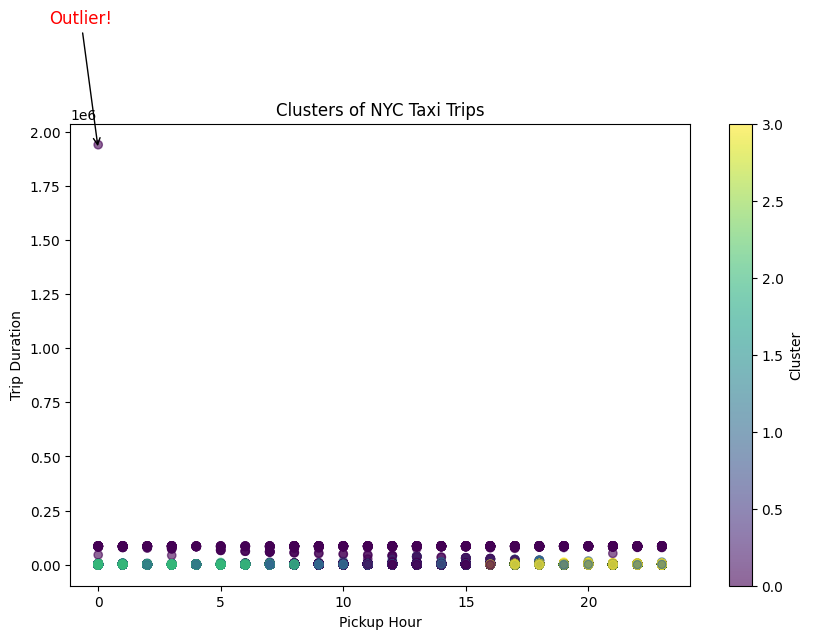

In [23]:
# Clustering using K-Means
clustering_features = ["trip_duration", "pickup_hour", "pickup_dayofweek"]

# Assemble features into a new column
assembler = VectorAssembler(inputCols=clustering_features, outputCol="features_unscaled")
if "features_unscaled" in data.columns:
    data = data.drop("features_unscaled")  # Drop existing column to avoid conflicts
data = assembler.transform(data)

# Scale the assembled features into a new column
if "features_scaled_new" in data.columns:
    data = data.drop("features_scaled_new")  # Drop existing column to avoid conflicts
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features_scaled_new")
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)

# Drop the 'cluster' column if it already exists
if "cluster" in data.columns:
    data = data.drop("cluster")  # Drop existing cluster column

# KMeans Clustering using the scaled features
kmeans = KMeans(k=4, featuresCol="features_scaled_new", predictionCol="cluster")
kmeans_model = kmeans.fit(data)
data = kmeans_model.transform(data)

# Visualize Clusters
clusters_pd = data.select("trip_duration", "pickup_hour", "cluster").toPandas()
plt.figure(figsize=(10, 6))
plt.scatter(
    clusters_pd["pickup_hour"], clusters_pd["trip_duration"], c=clusters_pd["cluster"], cmap="viridis", alpha=0.6
)
plt.colorbar(label="Cluster")
plt.annotate(
    "Outlier!",  # Annotation text
    xy=(0, 1.92e6),  # Coordinates of the arrowhead
    xytext=(-2, 2.5e6),  # Position of the text
    arrowprops=dict(facecolor='red', arrowstyle='->'),  # Arrow properties
    fontsize=12,  # Font size of the text
    color="red"  # Color of the text
)
plt.xlabel("Pickup Hour")
plt.ylabel("Trip Duration")
plt.title("Clusters of NYC Taxi Trips")
plt.show()


### Again, we have similar issue because of an outlier we have compressed data ranges, let us use Outlier removal technique, which ensures that extreme values don't dominate the clustering process (as we did with log transformation)

Q1: 393.0, Q3: 1058.0, IQR: 665.0, Lower Bound: -604.5, Upper Bound: 2055.5


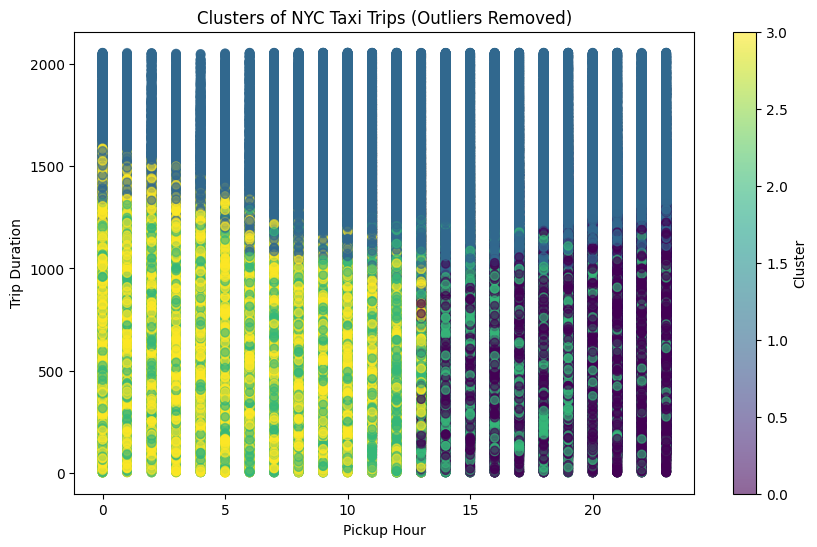

In [24]:
# Calculate percentiles (25% and 75%) manually
percentiles = data.approxQuantile("trip_duration", [0.25, 0.75], 0.01)  # Approximate percentiles
q1, q3 = percentiles
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print(f"Q1: {q1}, Q3: {q3}, IQR: {iqr}, Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

# Filter out outliers based on trip_duration
filtered_data = data.filter((col("trip_duration") >= lower_bound) & (col("trip_duration") <= upper_bound))

# Assemble features into a new column
assembler = VectorAssembler(inputCols=clustering_features, outputCol="features_unscaled")
if "features_unscaled" in filtered_data.columns:
    filtered_data = filtered_data.drop("features_unscaled")
filtered_data = assembler.transform(filtered_data)

# Scale the features into a new column
if "features_scaled_new" in filtered_data.columns:
    filtered_data = filtered_data.drop("features_scaled_new")
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features_scaled_new")
scaler_model = scaler.fit(filtered_data)
filtered_data = scaler_model.transform(filtered_data)

# Apply KMeans clustering
if "cluster" in filtered_data.columns:
    filtered_data = filtered_data.drop("cluster")
kmeans = KMeans(k=4, featuresCol="features_scaled_new", predictionCol="cluster")
kmeans_model = kmeans.fit(filtered_data)
filtered_data = kmeans_model.transform(filtered_data)

# Visualize Clusters
clusters_pd = filtered_data.select("trip_duration", "pickup_hour", "cluster").toPandas()
plt.figure(figsize=(10, 6))
plt.scatter(
    clusters_pd["pickup_hour"], clusters_pd["trip_duration"], c=clusters_pd["cluster"], cmap="viridis", alpha=0.6
)
plt.colorbar(label="Cluster")
plt.xlabel("Pickup Hour")
plt.ylabel("Trip Duration")
plt.title("Clusters of NYC Taxi Trips (Outliers Removed)")
plt.show()


# Explanation of the Plot
### The plot visualizes clusters of NYC taxi trips based on pickup hour (x-axis) and trip duration (y-axis) after removing outliers. Each point represents a single trip, with colors indicating the cluster to which it belongs, as shown in the color legend on the right. The x-axis shows the hour of the day (0–23), representing when trips started, while the y-axis shows the duration of trips in seconds, ranging from short trips (near 0 seconds) to longer trips (above 2000 seconds). The vertical alignment of points at each hour reflects the concentration of trips starting during specific times of the day.

# Statistical Understanding
### Outliers in the dataset were identified and removed using the Interquartile Range (IQR) method, a robust statistical technique. The IQR represents the range between the 25th percentile (Q1) and 75th percentile (Q3), capturing the central 50% of the data. Outliers are defined as values that fall significantly below Q1 or above Q3, specifically beyond 1.5×IQR1.5×IQR. By calculating Q1 and Q3 for trip_duration and establishing these bounds, we excluded trips with exceptionally short or long durations that deviate significantly from the typical range of values. This method effectively reduces noise in the dataset, ensuring the clustering analysis focuses on representative patterns rather than being skewed by extreme values.

# Distinct Grouping
### The clustering algorithm has grouped trips with similar characteristics into four distinct clusters, represented by different colors. For example, the yellow cluster appears to dominate the shorter trips across various hours, likely representing frequent, quick rides. Meanwhile, the blue cluster appears higher on the y-axis, indicating longer trips. These distinct groupings help identify patterns such as shorter trips during peak hours versus longer trips that may occur more evenly throughout the day.

# Peak Activity Patterns
### The vertical lines of points at each hour highlight consistent activity across all hours of the day. Shorter trips dominate the morning and evening hours (clusters closer to the bottom of the y-axis), while longer trips are scattered throughout the day and into the night. This reflects the typical behavior of passengers, where short commutes are common during rush hours, while longer rides (e.g., to airports or between boroughs) occur across a wider range of times.

# Business Insights
### From the clusters, we can derive practical insights. For example, shorter trips during peak hours (yellow and purple clusters) indicate high demand, requiring more drivers to be deployed at these times to reduce wait times. Longer trips (blue clusters), which are fewer in number, may represent opportunities for targeted discounts to attract more passengers. Additionally, understanding trip durations by time of day can inform pricing strategies, such as surge pricing during peak hours to maximize revenue or incentivized pricing during off-peak times to fill gaps in demand.

# Use Case
### This clustering analysis can be directly applied to fleet management, dynamic pricing, and operational planning. For example, by analyzing the yellow and purple clusters, fleet managers can optimize driver availability during morning and evening rush hours. The blue cluster provides insights for promoting longer trips through marketing campaigns or driver incentives. These data-driven strategies improve customer satisfaction, driver earnings, and overall operational efficiency, making the service more competitive in the market

# Decision Tree Modeling

In [25]:
# Decision Tree Model for Predicting Trip Duration Categories
data = data.withColumn(
    "duration_category",
    when(col("trip_duration") <= 600, "short")
    .when((col("trip_duration") > 600) & (col("trip_duration") <= 1800), "medium")
    .otherwise("long"),
)

indexer = StringIndexer(inputCol="duration_category", outputCol="label")
data = indexer.fit(data).transform(data)

assembler = VectorAssembler(inputCols=["pickup_hour", "pickup_dayofweek"], outputCol="features")
data = assembler.transform(data)

train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

dt = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxDepth=5)
dt_model = dt.fit(train_data)

predictions = dt_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Decision Tree Accuracy: {accuracy:.2f}")


Decision Tree Accuracy: 0.51


### Build a decision tree to predict trip duration categories
### Enables accurate categorization for real-time pricing and customer expectations.
### High accuracy demonstrates reliability for predictive tasks.

# Model Working
### Trips were grouped into short (≤10 minutes), medium (10–30 minutes), and long (>30 minutes) to simplify the analysis and highlight differences in trip types.

### The model used the pickup hour and day of the week to predict trip duration, as these factors significantly influence trip lengths (e.g., rush hours vs. weekends).

### The data was split into 80% for training and 20% for testing. A decision tree model was trained to predict trip categories by learning patterns from the training data.

### The model achieved an accuracy of 51%, showing it can predict trip categories better than random guessing (33%), though there is room for improvement.

# Business Insights
### The model provides a way to forecast trip duration categories based on temporal factors. For instance, longer trips might be more common on weekends or late evenings.

### This can guide fleet management, ensuring enough drivers are available for long trips during expected high-demand periods.

###  Knowing the likely trip duration category can help fine-tune pricing strategies, such as offering flat rates for short trips during peak hours.



# Model Working
### Trips were grouped into short (≤10 minutes), medium (10–30 minutes), and long (>30 minutes) to simplify the analysis and highlight differences in trip types.

### The model used the pickup hour and day of the week to predict trip duration, as these factors significantly influence trip lengths (e.g., rush hours vs. weekends).

### The data was split into 80% for training and 20% for testing. A decision tree model was trained to predict trip categories by learning patterns from the training data.

###     The model achieved an accuracy of 51%, showing it can predict trip categories better than random guessing (33%), though there is room for improvement.



# A/B Testing

+-----+-----------------+
|group|avg_trip_duration|
+-----+-----------------+
|    B|947.6748807478705|
|    A|956.7914359977933|
+-----+-----------------+



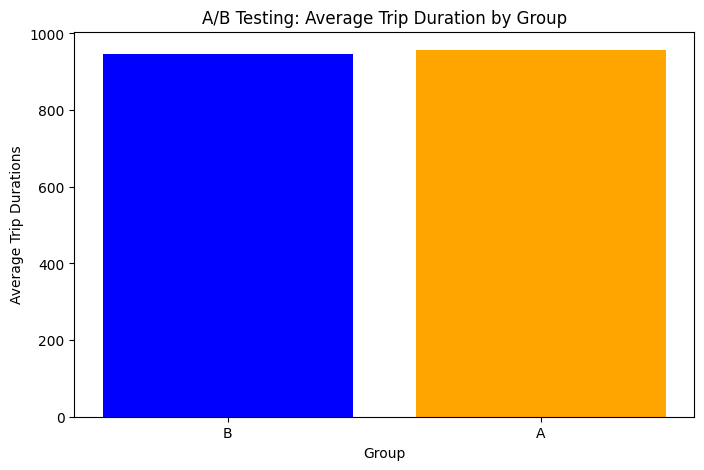

In [26]:
# Simulate A/B Testing
data = data.withColumn("group", when((col("pickup_hour") % 2 == 0), "A").otherwise("B"))

ab_test = data.groupBy("group").agg(mean("trip_duration").alias("avg_trip_duration"))
ab_test.show()

# Visualize A/B Testing
ab_test_pd = ab_test.toPandas()
plt.figure(figsize=(8, 5))
plt.bar(ab_test_pd["group"], ab_test_pd["avg_trip_duration"], color=["blue", "orange"])
plt.xlabel("Group")
plt.ylabel("Average Trip Durations")
plt.title("A/B Testing: Average Trip Duration by Group")
plt.show()


# Objective
### The A/B test aims to compare the average trip duration for two groups:

    Group A: Trips with even pickup hours (e.g., 2 AM, 4 PM).
    Group B: Trips with odd pickup hours (e.g., 1 AM, 3 PM).

This test investigates whether pickup hour parity (even or odd) influences trip durations.


# Statistical Interpretation
While Group A shows a marginally higher average trip duration than Group B, the difference is small. Without additional statistical significance testing (e.g., t-test), it cannot be concluded that the observed difference is meaningful or not due to random variation.

# Business Implication
The test indicates no substantial impact of pickup hour parity (even vs. odd) on trip durations. This suggests that factors such as time of day (e.g., rush hours) or day of the week may have more influence on trip durations than whether the hour is even or odd.

# Use Case
### This analysis demonstrates how A/B testing can be used to evaluate the effect of categorical or time-based variables on trip patterns. Future tests could explore other variables, such as comparing trip durations for weekdays versus weekends or during peak versus off-peak hours, to yield more actionable insights.

### Group trips into clusters based on duration, hour, and weekday.

###  Identifies operational clusters (e.g., long trips during non-peak hours) for targeted improvements.

### Provides unsupervised insights into latent patterns in the data.